## План работы
### 1. Изучение общей информации о данных
Проверка данных на наличие пропусков, проверка формата данных.
### 2. Предобработка данных
Обработка пропущенных и нулевых значений.
### 3. Анализ данных
Изучение продаж игр по годам. Выбор оптимального временного интервала для анализа. Построение распределения данных в разбивке по платформам и по жанрам. Выбор потенциально прибыльных платформ. Расчёт корреляции между продажами и отзывами.
### 4. Составление портрета пользователя по регионам
Поиск самых популярных платформ и жанров по регионам (Северная Америка, Европа, Япония).
### 5. Проверка гипотез
Проверка статистических гипотез о равенстве средних пользовательских рейтингов платформ Xbox One и PC, а также жанров Action  и Sports.

## Данные
В наличии были следующие данные:
- название игры
- платформа
- год выпуска
- жанр игры
- данные по продажам в Северной Америке, Европе, Японии и других странах)
- оценка критиков
- оценка пользователей
- рейтинг от организации ESRB

## 1. Изучение общей информации о данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats as st

data = pd.read_csv('../Games/games.csv')
display(data.head(10))
print()
print(data.info())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


В данных присутствует большое количество пропусков в столбцах Critic_Score, User_Score и Rating и умеренное количество пропусков в столбце Year_Of_Release. Данные в столбце User_Score типа object, а не ожидаемого float64. Данные в столбце Year_of_Release типа int вместо ожидаемого float64.

## 2. Предобработка данных

In [2]:
columns = [e.lower() for e in data.columns]
data.columns = columns

data['name'] = data['name'].dropna()
data['genre'] = data['genre'].dropna()

data['year_of_release'] = data['year_of_release'].fillna(0)
print("Количество пропусков в годе выпуска до обработки",
      len(data[data['year_of_release']==0]))
def fill_the_empty_years(row):
    """
    Заполняет год либо соответственно названию игры, либо если год
    указан для этой же игры, выпущенной на другой платформе
    """
    year = row['year_of_release']
    named = row['name']
    if year == 0:
        name_arr = named.split(' ')
        if name_arr[-1].isdigit()==True and year>1980:
            year = int(name_arr[-1])-1
        else:
            year = data.query('name == @named')['year_of_release'].max()
    return int(year)
data['year_of_release'] = data.apply(fill_the_empty_years, axis=1)
print("Количество пропусков в годе выпуска после обработки",
      len(data[data['year_of_release']==0]))

data['total_sales']=data['eu_sales']+data['jp_sales']+data['na_sales']

Количество пропусков в годе выпуска до обработки 269
Количество пропусков в годе выпуска после обработки 146


В столбцах genre и name присутствует всего по два пропуска, удалим эти строки. Пропуски в столбце year_of_release можно обработать следующим образом: в некоторых случаях год указан в названии игры (обычно это соответствует следующему после выпуска году, например, FIFA 2004 вышла в 2003 году и т.д.), в этих случаях можно заполнить год в соответствие с названием; кроме того, год выпуска может быть указан для этой же игры, но выпущенной на другой платформе. Следуя этой логике, можно сократить количество пропусков в столбце year_of_release практически вдвое. Здесь же создадим столбец с суммарными продажами.

In [3]:
data['critic_score'] = data['critic_score'].fillna(0) #обработка пропусков в оценках критиков
print("Количество пропусков в годе выпуска до обработки",
      len(data[data['critic_score']==0]))
def fill_critic_score(row):
    """
    Заполняет пропуски в оценке критиков
    средним значением для данной игры
    """
    score = row['critic_score']
    named = row['name']
    if score == 0:
        score = data.query('name == @named and critic_score!=0')['critic_score'].mean()
    return score
data['critic_score'] = data.apply(fill_critic_score, axis=1)
data['critic_score'] = data['critic_score'].fillna(0)
print(len(data[data['critic_score']==0]))

data['user_score'] = data['user_score'].fillna(0) #обработка пропусков в оценках пользователей
print(data['user_score'].unique())
print(len(data.query('user_score==0 or user_score=="tbd"')))

def cnangetype_user_score(row):
    """
    Меняет тип данных в оценках пользователей
    """
    score = row['user_score']
    if score!='tbd':
        score = float(score)
    return score

def fill_user_score(row):
    """
    Заполняет пропуски в оценках пользователей
    средним значением для данной игры
    """
    score = row['user_score']
    named = row['name']
    if score == 0 or score == 'tbd':
        score = data.query('name == @named and user_score!=0 and user_score!="tbd"')['user_score'].mean()
    return score

data['user_score'] = data.apply(cnangetype_user_score, axis=1)
data['user_score'] = data.apply(fill_user_score, axis=1)
data['user_score'] = data['user_score'].fillna(0)
print("Количество пропусков в годе выпуска до обработки",
      len(data.query('user_score==0 or user_score=="tbd"')))

Количество пропусков в годе выпуска до обработки 8578
7617
['8' 0 '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']
9125
Количество пропусков в годе выпуска до обработки 8027


В столбцах с оценками пользователей и критиков присутствуеют пропуски. Вероятно, они возникли в тех случаях, когда оценок было выставлено слишком мало, либо они обусловлены отсутствием оценок за игры старых годов выпуска, либо ошибками на стадии сбора данных. Также малым количеством оценок обусловлено появление единственного нечислового значения 'tbd' - To Be Determined - в столбце user_score. Пропуски в обоих столбцах можно заменить средним значением оценок для каждой конкретной игры. Однако в каждом случае заменена лишь 1/9 часть пропусков.

### Вывод

Необходимо проверить методику сбора данных, вероятно, на этой стадии были допущены некие ошибки, ведущие к большому количеству пропусков в столбцах с оценкой критиков и пользователей. Данные подготовлены к дальнейшему анализу.

## 3. Исследовательский анализ данных

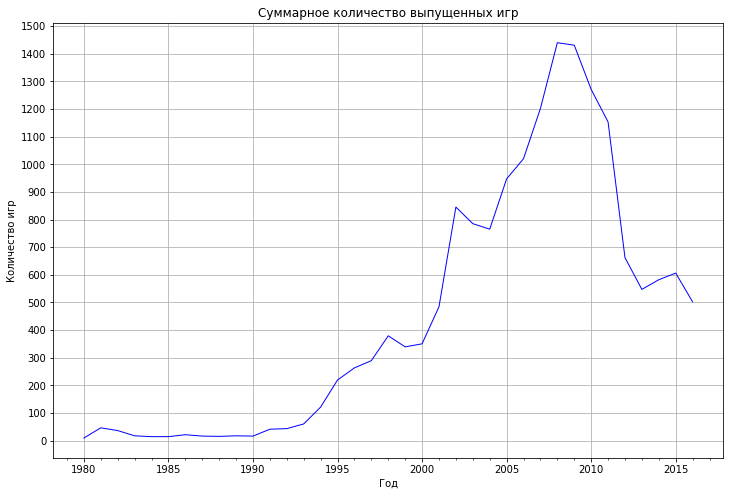

In [4]:
data_year = (data.query('year_of_release!=0')
             .pivot_table(index='year_of_release', values = 'name', aggfunc='count')
            )

fig, ax = plt.subplots()
ax.plot(data_year.index, data_year['name'], color='b', linewidth=1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
fig.set_figwidth(12)
fig.set_figheight(8)
plt.title('Суммарное количество выпущенных игр')
plt.ylabel('Количество игр')
plt.xlabel('Год')
plt.grid(True)

Построим график зависимости количества игр от года выпуска. Предварительно отметим, что для исследования можно отбросить данные до 2000 года - в этом году виден резкий скачок увеличения численности выпускаемых игр.

In [5]:
data_platform = (data.query('year_of_release>=2000')
                .pivot_table(index='year_of_release', columns='platform',
                             aggfunc='sum', values='total_sales', margins=True)
                .fillna(0)
                .astype('int64')
                .sort_values(by='All', axis=1, ascending=False)
                )
display(data_platform)

platform,All,PS2,X360,Wii,PS3,DS,GBA,PS4,PSP,XB,...,PC,XOne,PS,WiiU,PSV,N64,GB,DC,2600,WS
year_of_release,,,,,,,,,,,,,,,,,,,,,
2000,190,35,0,0,0,0,0,0,0,0,...,4,0,91,0,0,33,18,5,0,0
2001,309,149,0,0,0,0,59,0,0,22,...,5,0,33,0,0,3,9,1,0,0
2002,375,186,0,0,0,0,72,0,0,48,...,8,0,6,0,0,0,0,0,2,0
2003,340,171,0,0,0,0,55,0,0,54,...,8,0,1,0,0,0,0,0,0,0
2004,372,171,0,0,0,15,76,0,5,63,...,10,0,0,0,0,0,0,0,0,0
2005,419,141,8,0,0,119,33,0,37,47,...,4,0,0,0,0,0,0,0,0,0
2006,469,89,47,126,17,111,5,0,47,9,...,2,0,0,0,0,0,0,0,0,0
2007,529,52,86,139,62,136,3,0,38,0,...,8,0,0,0,0,0,0,0,0,0
2008,598,34,123,162,102,134,0,0,30,0,...,10,0,0,0,0,0,0,0,0,0


Сделаем сводную таблицу по суммарным продажам для разных платформ.

Для платформы PS2 игры выходили в течение 12 лет
Для платформы X360 игры выходили в течение 13 лет
Для платформы Wii игры выходили в течение 11 лет
Для платформы PS3 игры выходили в течение 12 лет
Для платформы DS игры выходили в течение 11 лет


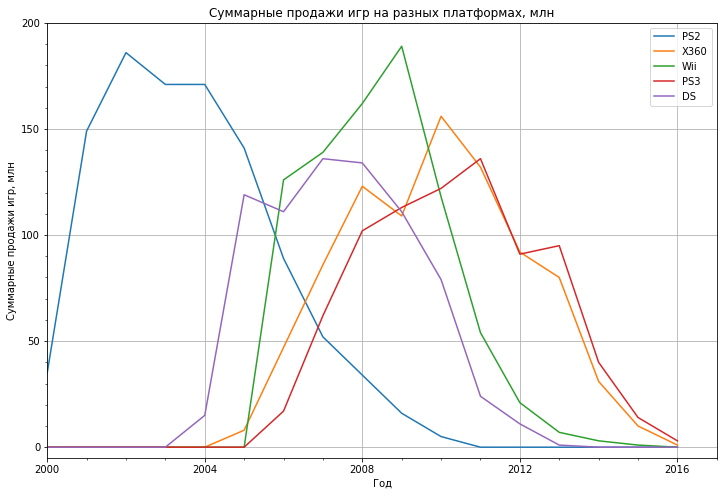

In [6]:
pop_platforms = ['PS2','X360','Wii','PS3','DS']
fig, ax = plt.subplots()
for element in pop_platforms:
    print('Для платформы', element, 'игры выходили в течение',
         len(data_platform[data_platform[element]!=0]), 'лет')
    ax.plot([int(e) for e in data_platform.index[:-1]], data_platform[element][:-1])

ax.xaxis.set_major_locator(ticker.MultipleLocator(4)) #настройка отображения графика
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))
fig.set_figwidth(12)
fig.set_figheight(8)
plt.title('Суммарные продажи игр на разных платформах, млн')
plt.ylabel('Суммарные продажи игр, млн')
plt.xlabel('Год')
plt.ylim(-5,200)
plt.xlim(2000,2017)
plt.grid(True)
plt.legend(['PS2','X360','Wii','PS3','DS'])

Построим распределение по годам для платформы с наибольшими суммарными продажами (PS2, X360, Wii, PS3, DS). Видно, что "срок жизни" платформы в среднем 12 лет, при этом, как правило, первые 4 года идёт резкий рост продаж, а затем медленный спад. Это означает, что для прогноза продаж на 2017 год можно взять только данные за последние 6 лет.

In [7]:
actual_data = data.query('year_of_release>2010')
actual_platform_year = (actual_data
                        .pivot_table(index='year_of_release', columns='platform',
                                     aggfunc='sum', values='total_sales', margins=True)
                        .fillna(0)
                        .astype('int64')
                        .sort_values(by='All', axis=1, ascending=False)
                        .drop(['PS2'], axis='columns')
                       )
display(actual_platform_year)

platform,All,PS3,X360,PS4,3DS,XOne,Wii,PC,WiiU,PSV,DS,PSP
year_of_release,,,,,,,,,,,,
2011,457,136,132,0,58,0,54,29,0,3,24,16
2012,323,91,92,0,49,0,21,20,16,13,11,7
2013,323,95,80,22,53,17,7,11,20,9,1,3
2014,295,40,31,84,41,49,3,12,20,10,0,0
2015,237,14,10,100,26,54,1,7,15,5,0,0
2016,115,3,1,59,14,23,0,4,4,4,0,0
All,1752,382,349,265,244,145,88,87,76,47,36,28


Сделаем сводную таблицу по суммарным продажам игр для разных платформ. Можно предположить, что потенциально прибыльными платформами являются Playstation 4 и Xbox One (первые 4-5 года существования платформы продажи обычно растут, и более низкая, чем в предыдующие годы, цифра продаж за 2016 год, может объясняться неполными данными за последний 2016 год).

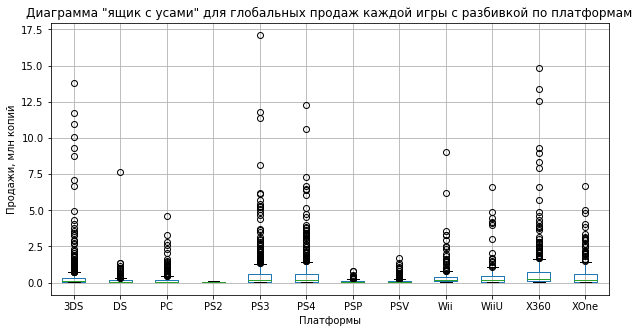

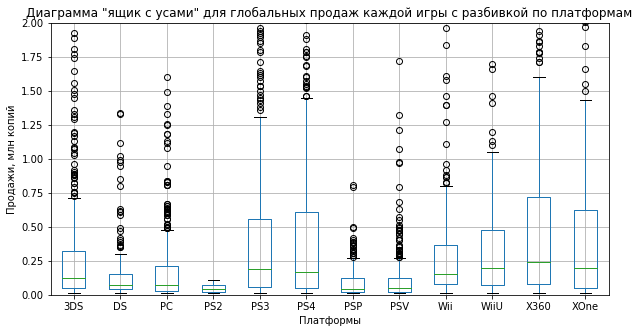

In [8]:
actual_games = (actual_data
                .pivot_table(index='name', aggfunc='sum', values='total_sales', columns='platform')
                )
actual_games.boxplot(figsize=(10,5))
plt.title('Диаграмма "ящик с усами" для глобальных продаж каждой игры с разбивкой по платформам')
plt.ylabel('Продажи, млн копий')
plt.xlabel('Платформы')
plt.show()
actual_games.boxplot(figsize=(10,5))
plt.ylim(0,2)
plt.ylabel('Продажи, млн копий')
plt.xlabel('Платформы')
plt.title('Диаграмма "ящик с усами" для глобальных продаж каждой игры с разбивкой по платформам')
plt.show()

Построим диаграмму "ящик с усами" по глобальным продажам каждой игры с разбивкой по платформам. Видно, что для всех платформ характерен очень большой разброс значений, при этом средние продажи не выходят за предел 0.25 миллионов копий. Максимальные продажи показывают платформы серии Playstation (PS3 и PS4) и серии XBox (X360 и XOne).

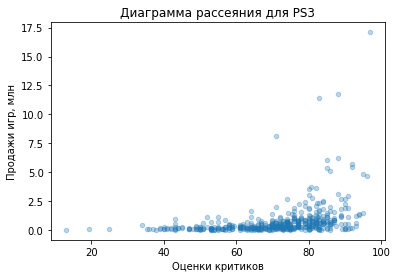

Коэффициент корреляции между оценками критиков и продажами игр для PS3 равен 0.352


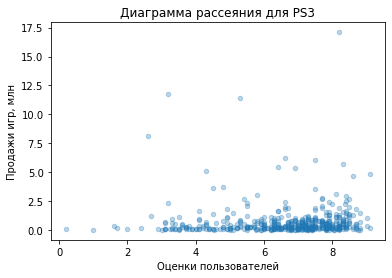

Коэффициент корреляции между оценками пользователей и продажами игр для PS3 равен 0.026


In [9]:
actual_critic_score = (actual_data
                       .query('platform=="PS3" and critic_score!=0')
                       .dropna(subset=['critic_score'])
                      )
actual_critic_score.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3)
plt.xlabel('Оценки критиков')
plt.ylabel('Продажи игр, млн')
plt.title('Диаграмма рассеяния для PS3')
plt.show()
print('Коэффициент корреляции между оценками критиков и продажами игр для PS3 равен {:.3f}'
      .format(actual_critic_score['total_sales'].corr(actual_critic_score['critic_score'])))

actual_user_score = (actual_data
                     .query('platform=="PS3" and user_score!=0 and user_score!="tbd"')
                     .dropna(subset=['user_score'])
                    )
actual_user_score.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3)
plt.xlabel('Оценки пользователей')
plt.ylabel('Продажи игр, млн')
plt.title('Диаграмма рассеяния для PS3')
plt.show()
print('Коэффициент корреляции между оценками пользователей и продажами игр для PS3 равен {:.3f}'
      .format(actual_user_score['total_sales'].corr(actual_user_score['user_score'])))

In [10]:
actual_critic_other = (actual_data
                       .query('platform!="PS3" and critic_score!=0')
                       .dropna(subset=['critic_score'])
                      )
print('Коэффициент корреляции между оценками критиков и продажами игр для остальных платформ равен {:.3f}'
      .format(actual_critic_other['total_sales'].corr(actual_critic_other['critic_score'])))

actual_user_other = (actual_data
                     .query('platform!="PS3" and user_score!=0 and user_score!="tbd"')
                     .dropna(subset=['user_score'])
                    )
print('Коэффициент корреляции между оценками пользователей и продажами игр для остальных платформ равен {:.3f}'
      .format(actual_user_other['total_sales'].corr(actual_user_other['user_score'])))

Коэффициент корреляции между оценками критиков и продажами игр для остальных платформ равен 0.298
Коэффициент корреляции между оценками пользователей и продажами игр для остальных платформ равен 0.050


В соответствие с расчётами коэффициента корреляции для самой популярной платформы Playstation 3 видно, что оценки пользователей абсолютно не коррелируют с продажами игр, а оценки критиков - коррелируют слабо. По диаграммам рассеяния видно, что некое подобие зависимости возникает только для оценок критиков выше 70, игры с более низкими оценками показывают околонулевые продажи, однако в случае с оценками пользователей высокие продажи могут показывать даже игры с низкими оценками. Для всех остальных платформ наблюдается аналогичная закономерность для количества продаж: слабая корреляция с оценками критиков и нулевая - с оценкамии пользователей.

,total_sales
genre,
Action,500.21
Shooter,354.42
Role-Playing,225.95
Sports,208.46
Misc,127.48
Platform,80.48
Racing,78.20
Fighting,60.25
Simulation,46.73


Text(0.5, 1.0, 'Распределение игр по продажам')

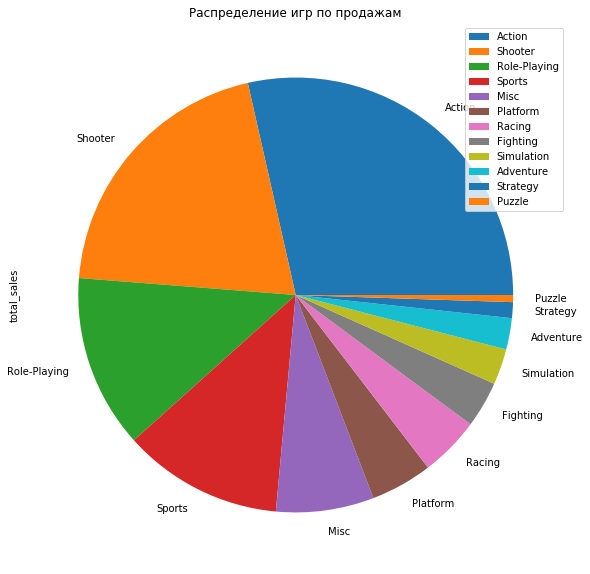

In [11]:
actual_genres = (actual_data
                .pivot_table(index='genre', aggfunc='sum', values='total_sales')
                .sort_values(by='total_sales', ascending=False)
                )
display(actual_genres)
actual_genres.plot.pie(y='total_sales', figsize=(10,10))
plt.title('Распределение игр по продажам')

Построим сводную таблицу по суммарным продажам игр по жанрам. Наиболее прибыльным жанром является Action, Shooter, Role-Playing и Sports, наименее прибыльные - Strategy и Puzzle.

### Вывод

Для исследования можно брать с 2000 года (в этом году резко возросло количество выпускаемых игр), однако прогноз на 2017 год можно построить по данным за последние 6 лет. В соотвествие с этими данными, потенциально прибыльными являются платформы Playstation 4 и Xbox One (265 и 145 млн проданных копий за последние 4 года соответственно, с тенденцией к увеличению продаж). Отзывы критиков можно принимать во внимание, однако обращать внимание на отзывы пользователей не стоит - они не коррелируют с цифрой продаж по платформам. Наиболее прибыльными являются жанры Action и Shooter (500.21 и 354.42 млн проданных копий соответственно), наименее прибыльными - Strategy и Puzzle (20.60 и 9.21 млн проданных копий соответственно).

## 4. Составление портрета пользователя по регионам

Самые популярные платформы в Европе (млн. проданных копий):
platform
PS3     164.15
PS4     141.09
X360    117.87
3DS      61.46
PC       57.38
Name: eu_sales, dtype: float64

Самые популярные платформы в Японии (млн. проданных копий):
platform
3DS    100.62
PS3     49.40
PSP     24.28
PSV     21.84
PS4     15.96
Name: jp_sales, dtype: float64

Самые популярные платформы в Северной Америке (млн. проданных копий):
platform
X360    228.18
PS3     168.96
PS4     108.74
XOne     93.12
3DS      82.83
Name: na_sales, dtype: float64



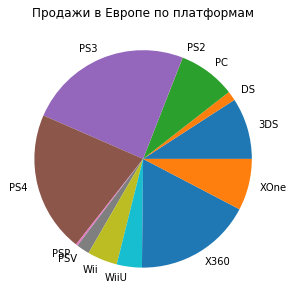

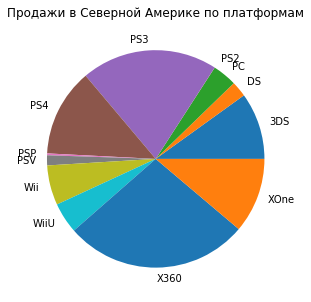

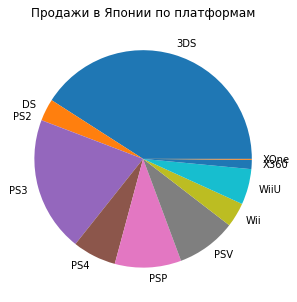

In [12]:
actual_platform_region = (actual_data
                          .pivot_table(index='platform', aggfunc='sum',
                                       values=['na_sales','jp_sales','eu_sales'])
                         )
print('Самые популярные платформы в Европе (млн. проданных копий):')
print(actual_platform_region.sort_values(by='eu_sales',ascending=False)['eu_sales'].head())
print()
print('Самые популярные платформы в Японии (млн. проданных копий):')
print(actual_platform_region.sort_values(by='jp_sales',ascending=False)['jp_sales'].head())
print()
print('Самые популярные платформы в Северной Америке (млн. проданных копий):')
print(actual_platform_region.sort_values(by='na_sales',ascending=False)['na_sales'].head())
print()
actual_platform_region['eu_sales'].plot(kind='pie', figsize=(5,5), label='')
plt.title('Продажи в Европе по платформам')
plt.show()
print()
actual_platform_region['na_sales'].plot(kind='pie', figsize=(5,5), label='')
plt.title('Продажи в Северной Америке по платформам')
plt.show()
actual_platform_region['jp_sales'].plot(kind='pie', figsize=(5,5), label='')
plt.title('Продажи в Японии по платформам')
plt.show()
print()

Как в Европе, так и в Америке по популярности лидируют платформы серий Playstation и Xbox - PS2, PS3, Xbox 360 и Xbox One. В Японии ситуация другая - более трети всего рынка занимает платформа Nintendo 3DS, ещё одну треть занимают платформы серии Playstation - PS3, PS4 и PSP. Таким образом, в Японии предпочтение отдаётся платформам, которые производят местные компании.

Самые популярные жанры в Европе (млн. проданных копий):
genre
Action          202.17
Shooter         148.05
Sports           88.67
Role-Playing     62.30
Racing           40.58
Name: eu_sales, dtype: float64

Самые популярные жанры в Японии (млн. проданных копий):
genre
Role-Playing    79.87
Action          63.63
Misc            17.85
Fighting        12.38
Platform        12.13
Name: jp_sales, dtype: float64

Самые популярные жанры в Северной Америке (млн. проданных копий):
genre
Action          234.41
Shooter         194.45
Sports          108.70
Role-Playing     83.78
Misc             69.81
Name: na_sales, dtype: float64



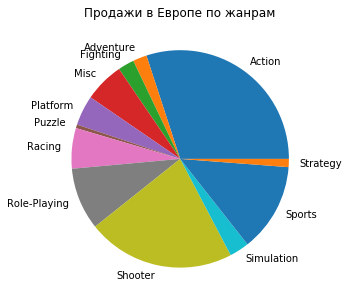

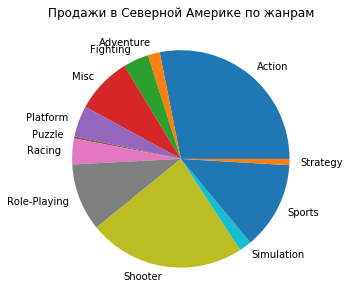

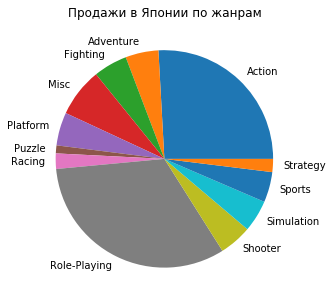

In [13]:
actual_genres_region = (actual_data
                          .pivot_table(index='genre', aggfunc='sum',
                                       values=['na_sales','jp_sales','eu_sales'])
                         )
print('Самые популярные жанры в Европе (млн. проданных копий):')
print(actual_genres_region.sort_values(by='eu_sales',ascending=False)['eu_sales'].head())
print()
print('Самые популярные жанры в Японии (млн. проданных копий):')
print(actual_genres_region.sort_values(by='jp_sales',ascending=False)['jp_sales'].head())
print()
print('Самые популярные жанры в Северной Америке (млн. проданных копий):')
print(actual_genres_region.sort_values(by='na_sales',ascending=False)['na_sales'].head())
print()
actual_genres_region['eu_sales'].plot(kind='pie', figsize=(5,5), label='')
plt.title('Продажи в Европе по жанрам')
plt.show()
print()
actual_genres_region['na_sales'].plot(kind='pie', figsize=(5,5), label='')
plt.title('Продажи в Северной Америке по жанрам')
plt.show()
print()
actual_genres_region['jp_sales'].plot(kind='pie', figsize=(5,5), label='')
plt.title('Продажи в Японии по жанрам')
plt.show()

Самые популярные жанры в Америке и Европе - Action, Sports и Shooter, при этом доля этих жанров в общем количестве игр практически одинакова для обоих регионов. В Японии же самым популярным жанром является Role-Playing, а второе место по популярности занимает Action. Интересно отметить стабильную популярность этого жанра - к играм жанра Action принадлежат примерно четверть всех игр в каждом из регионов.

,eu_sales,jp_sales,na_sales
rating,,,
E,141.93,36.68,170.25
E10+,79.88,11.23,119.95
M,251.40,26.15,309.32
T,83.37,33.39,109.62


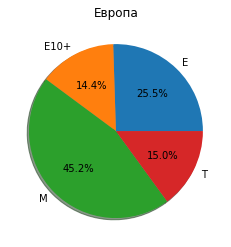

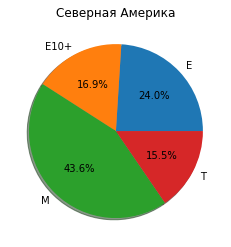

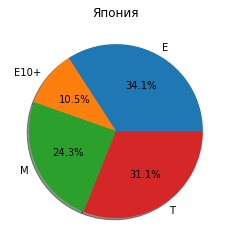

In [14]:
actual_rating_region = (actual_data.dropna(subset=['rating'])
                        .pivot_table(index='rating', aggfunc='sum',
                                     values=['na_sales','jp_sales','eu_sales'])
                        .query('index!="EC" and index!="RP"')
                       )
display(actual_rating_region)

fig, ax2 = plt.subplots()
ax2.pie(actual_rating_region['eu_sales'], labels=actual_rating_region.index,
        autopct='%1.1f%%', shadow=True, rotatelabels=False)
plt.title('Европа')
plt.show()

fig, ax4 = plt.subplots()
ax4.pie(actual_rating_region['na_sales'], labels=actual_rating_region.index,
        autopct='%1.1f%%', shadow=True, rotatelabels=False)
plt.title('Северная Америка')
plt.show()

fig, ax3 = plt.subplots()
ax3.pie(actual_rating_region['jp_sales'], labels=actual_rating_region.index,
        autopct='%1.1f%%', shadow=True, rotatelabels=False)
plt.title('Япония')
plt.show()

В сводной таблице по рейтингам игр уберем игры с рейтингом EC (Early Childhood, игры для детей) и с рейтингом RP (Rating Pending, игры с ещё не присвоенным рейтингом), так как суммарные продажи по играм с таким рейтингом крайне малы. В Северной Америке и Европе наиболее популярны игры для взрослых (рейтинг М), в Японии в основном популярны игры с рейтингом E и Т

### Вывод

Среднестатистический пользователь из Европы и Северной Америки играет в игры жанров Action/Shooter/Sports с рейтингом М, предпочитая платформы Playstation и Xbox. Среднестатистический пользователь из Японии играет в игры жанров Role-Playing/Action с рейтингом Е или Т, предпочитая платформы Playstation и Nintendo 3DS.

## 5. Проверка гипотез

In [15]:
xbox_one_user_score = list(actual_data.dropna(subset=['user_score'])
                           .query('platform=="XOne" and user_score!=0 and user_score!="tbd"')['user_score'])
pc_user_score = list(actual_data.dropna(subset=['user_score'])
                     .query('platform=="PC" and user_score!=0 and user_score!="tbd"')['user_score'])

print('Средний пользовательский рейтинг платформы Xbox One равен {:.1f}'
      .format(np.mean(xbox_one_user_score)),
      'с дисперсией {:.1f}'.format(np.var(xbox_one_user_score)))
print('Средний пользовательский рейтинг платформы PC равен {:.1f}'
      .format(np.mean(pc_user_score)),
      'с дисперсией {:.1f}'.format(np.var(pc_user_score)))
print()

alpha = .05
results = st.ttest_ind(xbox_one_user_score, pc_user_score, equal_var = False)
print('p-значение: {:.3f}'.format(results.pvalue))
if (results.pvalue<alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

Средний пользовательский рейтинг платформы Xbox One равен 6.6 с дисперсией 1.9
Средний пользовательский рейтинг платформы PC равен 6.5 с дисперсией 2.6

p-значение: 0.273
Не отвергаем нулевую гипотезу


Нулевая гипотеза: Средний пользовательский рейтинг платформы Xbox One не отличается от среднего пользовательского рейтинга платформы PC. Альтернативная гипотеза: средний пользовательский рейтинг платформы Xbox One отличается от среднего пользовательского рейтинга платформы PC. Используем t-тест на этих двух наборах несвязанных между собой данных, учтём то, что дисперсии у двух выборок сильно различаются между собой. Высокое значение p-value говорит о том, что различия между рейтингами с большой вероятностью возникли случайно, следовательно, нельзя отвергнуть нулевую гипотезу.

In [16]:
action_user_score = list(actual_data.dropna(subset=['user_score'])
                         .query('genre=="Action" and user_score!=0 and user_score!="tbd"')['user_score'])
sports_user_score = list(actual_data.dropna(subset=['user_score'])
                         .query('genre=="Sports" and user_score!=0 and user_score!="tbd"')['user_score'])

print('Средний пользовательский рейтинг жанра Action равен {:.1f}'
      .format(np.mean(action_user_score)),
      'с дисперсией {:.1f}'.format(np.var(action_user_score)))
print('Средний пользовательский рейтинг жанра Sports равен {:.1f}'
      .format(np.mean(sports_user_score)),
      'с дисперсией {:.1f}'.format(np.var(sports_user_score)))
print()

results2 = st.ttest_ind(action_user_score, sports_user_score, equal_var = False)
print('p-значение: {:.3f}'.format(results2.pvalue))
if (results2.pvalue<alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

Средний пользовательский рейтинг жанра Action равен 6.8 с дисперсией 1.8
Средний пользовательский рейтинг жанра Sports равен 5.6 с дисперсией 2.8

p-значение: 0.000
Отвергаем нулевую гипотезу


Нулевая гипотеза: средний пользовательский рейтинг жанра Action не отличается от среднего пользовательского рейтинга жанра Sports. Альтернативная гипотеза: средний пользовательский рейтинг жанра Action отличается от среднего пользовательского рейтинга жанра Sports. Используем t-тест на этих двух наборах несвязанных между собой данных, учтём то, что дисперсии у двух выборок сильно различаются между собой. Низкое значение p-value говорит о том, что различия между рейтингами значимы и неслучайны, следовательно, отвергаем нулевую гипотезу.

### Вывод

Средний пользовательский рейтинг платформ PC и Xbox One совпадает, средний пользовательский рейтинг жанра Action отличается от жанра Sports.

## Общий вывод

При планировании рекламных компаний необходимо ориентироваться на данные за последние 6 лет и принимать во внимание оценки критиков, однако нет необходимости обращать внимание на пользовательские оценки. Не следует делать различий между регионами Северная Америка и Европа, однако необходим особый подход к Японии. В Северной Америке и Европе необходимо отдавать предпочтение играм с рейтингами М и Е (45% и 25% рынка соответственно), принадлежащим к жанрам Action, Shooter и Sports (430, 240 и 190 млн проданных копий в сумме соответственно); В Японии необходимо отдавать предпочтение играм с рейтингами Е и Т (34% и 31% рынка соответственно), принадлежащим к жанрам Role-Playing и Action (80 и 63 млн проданных копий в сумме соответственно).